In [1]:
# PYTHON IMPORTS
import os
import copy
from tqdm.notebook import trange, tqdm

# IMAGE IMPORTS 
from PIL import Image
import cv2

# DATA IMPORTS 
import random
import h5py
import numpy as np

# PLOTTING
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# NEURAL NETWORK
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.transforms import ToPILImage, GaussianBlur
from torchvision.transforms import Compose, RandomCrop, ToTensor, Normalize
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# MY OWN CLASSES
from SquareLocator import *
Image.MAX_IMAGE_PIXELS = 933120000

verbose_level = 1

In [2]:
base_dir = r"C:\Users\fhacesga\OneDrive - University Of Houston\AAA_RECTDNN\data"

input_folder        = f"{base_dir}/SquareLocator/in"
val_folder          = f"{base_dir}/SquareLocator/val"
train_target_folder = f"{base_dir}/SquareLocator/out"
val_target_folder   = f"{base_dir}/SquareLocator/val_out"
batch_size = 8

transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

tensor = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = SquareDataset_Multiclass(input_folder, train_target_folder, transform=transform, 
                                         crop=False, 
                                         resize=True,
                                         resize_def=512,
                                        )
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

val_dataset   = SquareDataset_Multiclass(val_folder, val_target_folder, transform=transform, 
                                         crop=False, 
                                         resize=True,
                                         resize_def=512,
                                        )
val_loader  = DataLoader(val_dataset, batch_size=2, shuffle=True, num_workers=0)

loaders = {'train' : train_loader, "test" : val_loader }

72768287
72150850
72469828
72453067
84903579
55143349
18179326
7783887
72076109
73090043
71838340


In [5]:
torch.min(train_dataset[0][1])

tensor(0)

In [7]:
def notify(mess, level=4):
    if verbose_level >= level:
        print(mess)
        
def saveImages(prob_img_or, outputs, filenames, minputs, outputs_folder, rep_id):
    
    # IF FOR SOME REASON OUTPUT IS UNBATCHED, BATCH IT
    if prob_img_or.ndim == 3:
        prob_img_or = prob_img_or.unsqueeze(0)
    prob_img_or = prob_img_or.numpy()
    
    # FOR EACH BATCHED OUTPUT
    for i in range(len(outputs)):
        filename = filenames[i]
        
        # FOR EACH CLASS
        for ii in range(prob_img_or.shape[1]):
            
            # GET CURRENT PROBABILITY IMAGE AND SAVE
            prob_img = prob_img_or[i, ii, :, :]
            prob_img = (prob_img * 255).astype(np.uint8) 
            prob_img = Image.fromarray(np.squeeze(prob_img))
            prob_img.save(os.path.join(outputs_folder, f"{rep_id}_{ii}_{filename}"))
        
        # SAVE INPUTS
        myinp = Image.fromarray(np.uint8(minputs[i, 0, :, :] * 255))
        myinp.save(os.path.join(outputs_folder, f"{rep_id}_{filename[:-3]}_inp.png"))

def train(model, dataloaders, num_epochs=50, 
          output_dir=f'{base_dir}/SquareLocator/intermediate_outputs', 
          learning_rate=5e-4,
          device = torch.device("cuda:0"),
          weights=[1, 120]):
    
    # TRAINING PARAMETERS
    weights = torch.tensor(weights).float().to(device)
    criterion = nn.CrossEntropyLoss(weight=weights, reduction="mean")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    learning_rate_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.97)
        
    # SEND MODEL TO GPU
    model = model.to(device)
    
    # MAKE SURE DIRS FOR TEMP OUTPUTS EXIST
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # LOOP THROUGH EPOCHS
    for epoch in range(num_epochs):
        notify('Epoch {}/{}'.format(epoch+1, num_epochs), level=1)
        notify('-' * 10, level=1)
        epoch_loss = 0
        
        # FOR BOTH PHASES
        for phase in ['train', 'test']: 
            if phase == 'train':
                model.train()
                repeats = range(4)
            else:
                model.eval()
                repeats = range(1)
            
            # MAKE DIR FOR CURRENT PHASE IF IT DOES NOT EXIST
            outputs_folder = os.path.join(output_dir, phase)
            if not os.path.exists(outputs_folder):
                os.makedirs(outputs_folder)
                
            # BASELINE MEMORY USAGE                
            notify(f"Prior to Iterations\t {torch.cuda.memory_allocated() / 1e6}")
            
            # ITERATE OVER REPEATS
            for rep_id in tqdm(repeats):
                for inputs, labels, filenames in dataloaders[phase]:
                    
                    plt.hist(inputs.flatten())
                    plt.show()
                    plt.hist(labels.flatten())
                    plt.show()
                    error
                    
                    # SEND TO GPU
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    notify(f"Datasets Moved\t\t {torch.cuda.memory_allocated()/ 1e6}")
                    
                    # ZERO GRADIENTS AND THROUGH MODEL
                    optimizer.zero_grad()
                    outputs = model(inputs, resize=False)
                    
                    
                    
                    
                    
                    notify(f"Outputs Processed\t {torch.cuda.memory_allocated() / 1e6}")
                    
                    # CALCULATE LOSS AND KEEP TRACK OF IT FOR CURRENT EPOCH
                    loss = criterion(outputs, labels) 
                    epoch_loss += loss
                    notify(f"Loss Calculated\t\t {torch.cuda.memory_allocated() / 1e6}")
                    
                    # OPTIMIZE IF PHASE IS TRAINING
                    if phase is 'train':
                        notify("Optimizing", level=1)
                        loss.backward()
                        optimizer.step()
                        notify(f"Backwards and optimized\t {torch.cuda.memory_allocated() / 1e6}")
                    
                    # SAVE TRAINING IMAGES IF CURRENT STEP REQUIRES IT
                    if rep_id % 2 == 0 and rep_id != 0:
                        prob_img_or = outputs.detach().cpu()
                        minputs     = inputs.detach().cpu().numpy()
                        saveImages(prob_img_or, outputs, filenames, minputs, outputs_folder, rep_id)
                    
                    # EMPTY CACHE
                    torch.cuda.empty_cache()
                    notify(f"Cache Emptied\t\t {torch.cuda.memory_allocated() / 1e6}")
                    
            notify('{} Loss: {:.4f}'.format(phase, epoch_loss), level=1)
            
        # UPDATE LEARNING RATE SCHEDULER
        learning_rate_scheduler.step()
        notify(f"Learning Rate: {optimizer.param_groups[0]['lr']}", level=1)
        
        # SAVE MODEL EVERY TEN EPOCHS
        if epoch % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }, f'{base_dir}/SquareLocator/checkpoint_072723.pth')
            
            torch.save(model, f"{base_dir}/SquareLocator/072723.pth")
        
    return model

Epoch 1/2500
----------


  0%|          | 0/4 [00:00<?, ?it/s]

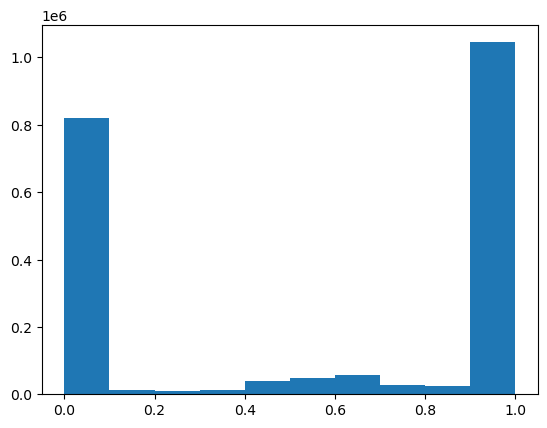

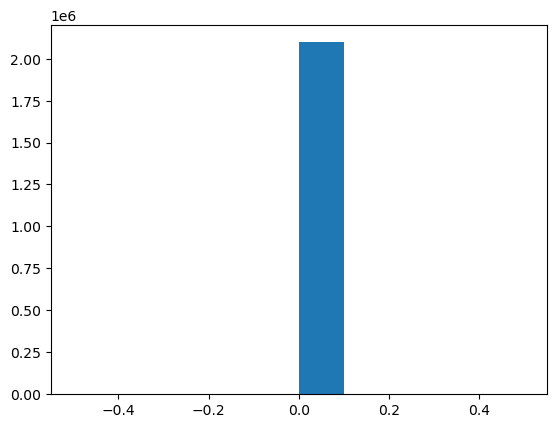

NameError: name 'error' is not defined

In [8]:
model = SquareLocator(finalpadding=1)
model = train(model, loaders, num_epochs=2500, learning_rate=1e-3)